<a href="https://colab.research.google.com/github/Lelouchlamperougexd/article_experiment/blob/main/exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Packages
!pip install datasets pandas numpy torch tqdm faiss-cpu sentence-transformers transformers openpyxl kaggle

# Libraries
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import faiss
from sentence_transformers import SentenceTransformer
import json
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Set up Kaggle API and download dataset
print("Downloading ArXiv dataset from Kaggle...")
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# Download dataset
!kaggle datasets download -d cornell-university/arxiv --unzip

# Path to dataset file
FILE_PATH = "arxiv-metadata-oai-snapshot.json"


Dataset URL: https://www.kaggle.com/datasets/cornell-university/arxiv
License(s): CC0-1.0
 99% 1.39G/1.40G [00:05<00:00, 328MB/s]
100% 1.40G/1.40G [00:05<00:00, 267MB/s]


In [5]:
# Load dataset from JSON
print("Loading ArXiv dataset...")
try:
    with open(FILE_PATH, "r") as f:
        arxiv_data = [json.loads(line) for line in f]

    docs_arxiv_df = pd.DataFrame(arxiv_data)

    # Keep only necessary columns
    docs_arxiv_df = docs_arxiv_df[['id', 'title', 'abstract', 'categories', 'update_date']]
    docs_arxiv_df = docs_arxiv_df.rename(columns={'id': 'doc_id'})

    # Process full text
    docs_arxiv_df['full_text'] = docs_arxiv_df['title'] + ". " + docs_arxiv_df['abstract'].fillna("")

    # Convert date
    docs_arxiv_df['update_date'] = pd.to_datetime(docs_arxiv_df['update_date'], errors='coerce')

    # Remove NaT dates
    docs_arxiv_df = docs_arxiv_df.dropna(subset=['update_date'])

    # Split into old (before 2020) and new (2021+), limiting to 5000 each for performance
    old_docs_df = docs_arxiv_df[docs_arxiv_df['update_date'] < '2020-01-01'].sample(n=5000, random_state=42)
    new_docs_df = docs_arxiv_df[docs_arxiv_df['update_date'] >= '2021-01-01'].sample(n=5000, random_state=42)

    print(f"Loaded {len(docs_arxiv_df)} total documents.")
    print(f"Filtered {len(old_docs_df)} old papers and {len(new_docs_df)} new papers.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    old_docs_df = new_docs_df = pd.DataFrame()

Loading ArXiv dataset...
Loaded 2677526 total documents.
Filtered 5000 old papers and 5000 new papers.


In [6]:
# Create FAISS index for old papers
print("Creating FAISS index for old papers...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Compact transformer model
old_texts = old_docs_df['full_text'].tolist()
old_doc_ids = old_docs_df['doc_id'].tolist()

# Encode documents into embeddings
old_embeddings = model.encode(old_texts, convert_to_tensor=True)
old_embeddings_np = old_embeddings.cpu().numpy()

# Normalize for cosine similarity
faiss.normalize_L2(old_embeddings_np)
index = faiss.IndexFlatIP(old_embeddings_np.shape[1])
index.add(old_embeddings_np)


Creating FAISS index for old papers...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# Function to determine novelty

def evaluate_novelty(new_text, top_k=5):
    """Evaluate novelty of a new article by comparing with old papers."""
    new_embedding = model.encode([new_text], convert_to_tensor=True).cpu().numpy()
    faiss.normalize_L2(new_embedding)
    scores, indices = index.search(new_embedding, k=top_k)
    avg_similarity = np.mean(scores)
    novelty_score = 1 - avg_similarity  # Higher score means more novel
    return novelty_score

# Run novelty evaluation
print("Evaluating novelty of new papers...")
novelty_results = []
for _, row in tqdm(new_docs_df.iterrows(), total=len(new_docs_df)):
    novelty_score = evaluate_novelty(row['full_text'])
    novelty_results.append({'doc_id': row['doc_id'], 'title': row['title'], 'novelty_score': novelty_score})


Evaluating novelty of new papers...


100%|██████████| 5000/5000 [03:24<00:00, 24.45it/s]


In [8]:
# sort by novelty
novelty_df = pd.DataFrame(novelty_results).sort_values(by='novelty_score', ascending=False)
print("Top 10 most novel papers:")
print(novelty_df.head(10))

Top 10 most novel papers:
          doc_id                                              title  \
2894  2310.00939  Estimation of In-Vitro Free Radical Scavenging...   
4987  2310.17686  Submandibular Sialolithiasis in a 9-year-old c...   
4779  2312.14515  Does religiosity influence corporate greenwash...   
775   2304.03476  Generalizing the intention-to-treat effect of ...   
1934  2404.05737  Soil respiration signals in response to sustai...   
2186  2403.05479  The temperature affects the impact levels of s...   
886   2012.09336  Levelling Down and the COVID-19 Lockdowns: Une...   
4324  2107.13521  Disability in Space -- What ESA should have ai...   
4102  2112.13849  The Long-Run Impact of Electoral Violence on H...   
3595  2407.13131  Reimagining Communities through Transnational ...   

      novelty_score  
2894       0.830037  
4987       0.808980  
4779       0.779802  
775        0.761980  
1934       0.760649  
2186       0.760107  
886        0.739901  
4324       0.720

In [9]:
# Save results
novelty_df.to_csv("novelty_results.csv", index=False)
print("Saved novelty results to novelty_results.csv")

Saved novelty results to novelty_results.csv


In [10]:
print(novelty_df["novelty_score"].describe())

count    5000.000000
mean        0.481964
std         0.074082
min         0.230885
25%         0.435448
50%         0.482700
75%         0.529893
max         0.830037
Name: novelty_score, dtype: float64


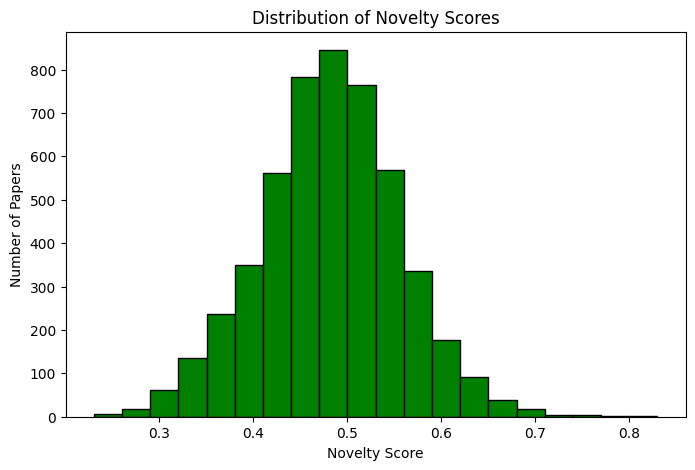

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(novelty_df["novelty_score"], bins=20, color="green", edgecolor="black")
plt.xlabel("Novelty Score")
plt.ylabel("Number of Papers")
plt.title("Distribution of Novelty Scores")
plt.show()


In [13]:
print(novelty_df.nsmallest(10, "novelty_score"))


          doc_id                                              title  \
448   2111.02539  Host galaxy properties of X-ray AGN in the Loc...   
560   2011.10350  Investigating the transverse momentum dependen...   
1498  2301.02209  Spatially Resolved Stellar Populations of $0.3...   
1755  2207.12429  Cosmological Constraints from Galaxy Clusters ...   
2278  2309.13374  Catalogue of model star clusters in the Milky ...   
640   2109.00576  Spatially resolved Lyman-$\alpha$ emission aro...   
2682  2012.12887  SDSS-IV/MaNGA: Can impulsive gaseous inflows e...   
3515  2209.12465  Neutrino non-radiative decay and the diffuse s...   
1638  2107.02695  Towards a More Complex Understanding of Natal ...   
4128  2101.02407  Intrinsic color diversity of nearby type Ia su...   

      novelty_score  
448        0.230885  
560        0.244926  
1498       0.248589  
1755       0.251019  
2278       0.252664  
640        0.256020  
2682       0.261040  
3515       0.263225  
1638       0.268017 